In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
%matplotlib inline

In [2]:
df = pd.read_csv('data_to_ml.csv')
df.sample(10)

,Faction,Class,KB,D,HK,DD,HD,Honor,Win,Lose,Rol,BE,Class Type,Pets,Armor Type
3172,Alliance,Demon Hunter,7,0,36,81271,7695,559,1,0,dps,0,Melee,0,Leather
1558,Alliance,Druid,3,6,16,67213,18236,243,0,1,dps,0,Both,0,Leather
48,Horde,Druid,3,3,10,55534,11397,136,0,1,dps,0,Both,0,Leather
3272,Alliance,Druid,1,1,15,31043,25938,236,0,1,dps,0,Both,0,Leather
2436,Horde,Warlock,2,3,11,19341,8754,428,1,0,dps,1,Ranged,1,Cloth
1288,Horde,Paladin,1,2,30,9302,128000,367,1,0,heal,0,Both,0,Plate
2076,Alliance,Demon Hunter,1,3,22,58282,42960,382,0,1,dps,1,Melee,0,Leather
3972,Horde,Druid,2,2,36,50098,11640,253,0,1,dps,0,Both,0,Leather
2029,Alliance,Rogue,0,2,8,11788,5598,274,0,1,dps,1,Melee,0,Leather
2199,Horde,Paladin,7,1,26,37652,13572,510,1,0,dps,0,Both,0,Plate


In [3]:
X = df.drop('Faction', axis=1)
y = df['Faction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_columns = ['Class', 'Rol', 'Class Type', 'Armor Type']
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

X_train.drop(categorical_columns, axis=1, inplace=True)
X_test.drop(categorical_columns, axis=1, inplace=True)

X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded_df], axis=1)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [4]:
pipeline_minmax = make_pipeline(MinMaxScaler(), LogisticRegression())
param_grid_minmax = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'logisticregression__max_iter': [1000, 2000, 3000],
    'logisticregression__class_weight': [None, 'balanced'],
}
random_search_minmax = RandomizedSearchCV(pipeline_minmax, param_grid_minmax, n_iter=50, cv=5, n_jobs=-1, 
                                          verbose=1, random_state=42)

random_search_minmax.fit(X_train, y_train_encoded)
y_pred_test_minmax = random_search_minmax.predict(X_test)
y_pred_train_minmax = random_search_minmax.predict(X_train)

y_test_labels_minmax = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels_minmax = label_encoder.inverse_transform(y_pred_test_minmax)
y_train_labels_minmax = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels_minmax = label_encoder.inverse_transform(y_pred_train_minmax)

accuracy_minmax = accuracy_score(y_test_labels_minmax, y_pred_test_labels_minmax)

print("MinMaxScaler best params:", random_search_minmax.best_params_)
print("MinMaxScaler accuracy:", accuracy_minmax)
print("MinMaxScaler best score:", random_search_minmax.best_score_)
print("Classification Report for Test Data")
print(classification_report(y_test_labels_minmax, y_pred_test_labels_minmax))
print("Classification Report for Training Data")
print(classification_report(y_train_labels_minmax, y_pred_train_labels_minmax))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
MinMaxScaler best params: {'logisticregression__solver': 'lbfgs', 'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 1000, 'logisticregression__class_weight': None, 'logisticregression__C': 100}
MinMaxScaler accuracy: 0.8022284122562674
MinMaxScaler best score: 0.8030685195814504
Classification Report for Test Data
              precision    recall  f1-score   support

    Alliance       0.80      0.79      0.80       526
       Horde       0.81      0.81      0.81       551

    accuracy                           0.80      1077
   macro avg       0.80      0.80      0.80      1077
weighted avg       0.80      0.80      0.80      1077

Classification Report for Training Data
              precision    recall  f1-score   support

    Alliance       0.81      0.81      0.81      2153
       Horde       0.81      0.82      0.81      2153

    accuracy                           0.81      4306
   macro avg      

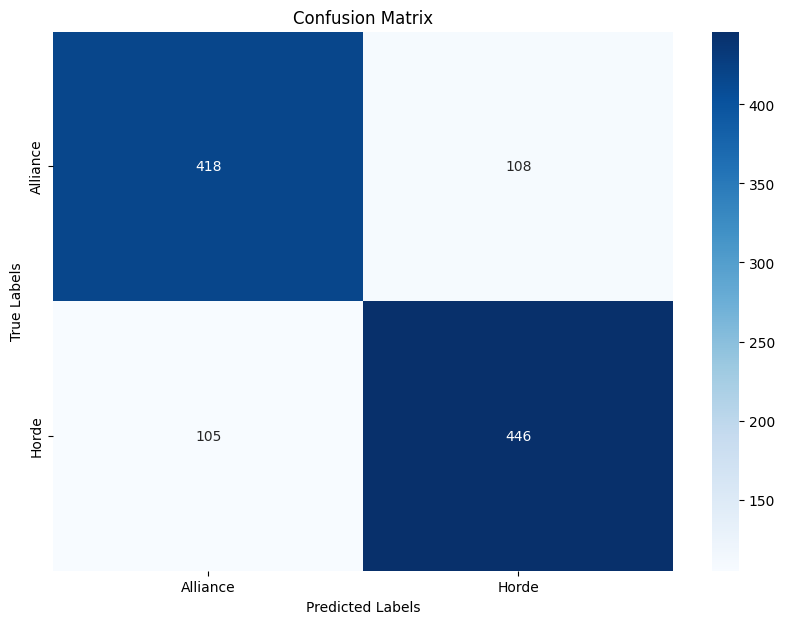

In [5]:
conf_matrix_minmax = confusion_matrix(y_test_labels_minmax, y_pred_test_labels_minmax)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_minmax, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/faction_cm_minmax.png')


plt.show()

In [6]:
pipeline_standard = make_pipeline(StandardScaler(), LogisticRegression())
param_grid_standard = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'logisticregression__max_iter': [1000, 2000, 3000],
    'logisticregression__class_weight': [None, 'balanced'],
}
random_search_standard = RandomizedSearchCV(pipeline_standard, param_grid_standard, n_iter=50, cv=5, n_jobs=-1, 
                                   verbose=1, random_state=42)

random_search_standard.fit(X_train, y_train_encoded)
y_pred_test_standard = random_search_standard.predict(X_test)
y_pred_train_standard = random_search_standard.predict(X_train)

y_test_labels_standard = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels_standard = label_encoder.inverse_transform(y_pred_test_standard)
y_train_labels_standard = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels_standard = label_encoder.inverse_transform(y_pred_train_standard)

accuracy_standard = accuracy_score(y_test_labels_standard, y_pred_test_labels_standard)

print("StandardScaler best params:", random_search_standard.best_params_)
print("StandardScaler accuracy:", accuracy_standard)
print("StandardScaler best score:", random_search_standard.best_score_)
print("Classification Report for Test Data")
print(classification_report(y_test_labels_standard, y_pred_test_labels_standard))
print("Classification Report for Training Data")
print(classification_report(y_train_labels_standard, y_pred_train_labels_standard))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
StandardScaler best params: {'logisticregression__solver': 'lbfgs', 'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 1000, 'logisticregression__class_weight': None, 'logisticregression__C': 10}
StandardScaler accuracy: 0.8022284122562674
StandardScaler best score: 0.8023721944213145
Classification Report for Test Data
              precision    recall  f1-score   support

    Alliance       0.80      0.79      0.80       526
       Horde       0.81      0.81      0.81       551

    accuracy                           0.80      1077
   macro avg       0.80      0.80      0.80      1077
weighted avg       0.80      0.80      0.80      1077

Classification Report for Training Data
              precision    recall  f1-score   support

    Alliance       0.81      0.81      0.81      2153
       Horde       0.81      0.81      0.81      2153

    accuracy                           0.81      4306
   macro avg 

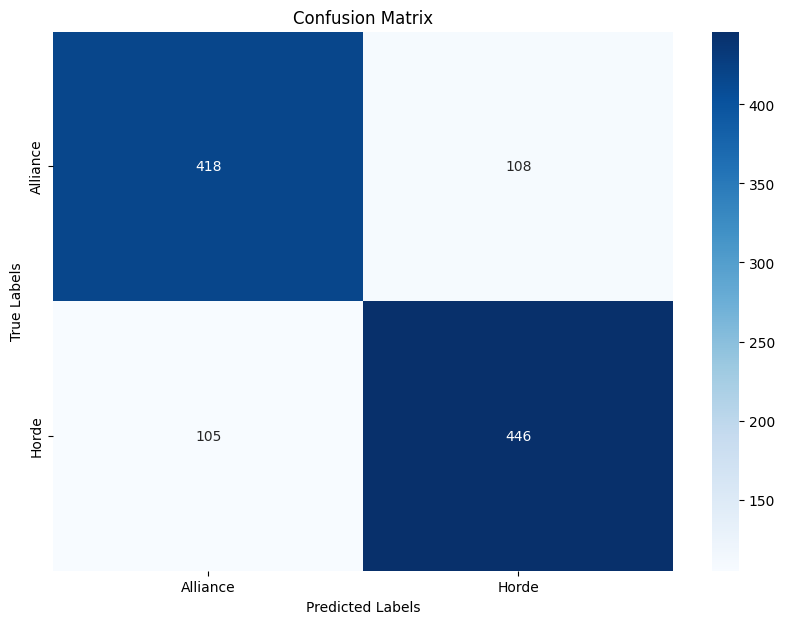

In [7]:
conf_matrix_standard = confusion_matrix(y_test_labels_standard, y_pred_test_labels_standard)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_standard, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/faction_cm_standard.png')

plt.show()

In [8]:
param_grid_decision_tree = {
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 8, 64],
    'max_features': [None, 'sqrt', 'log2'],
}

decision_tree = DecisionTreeClassifier()

random_search_dt = RandomizedSearchCV(decision_tree, param_grid_decision_tree, n_iter=50, cv=5, n_jobs=-1, 
                                   verbose=1, random_state=42)

random_search_dt.fit(X_train, y_train_encoded)

y_pred_test_dt = random_search_dt.predict(X_test)
y_pred_train_dt = random_search_dt.predict(X_train)

y_test_labels_dt = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels_dt = label_encoder.inverse_transform(y_pred_test_dt)
y_train_labels_dt = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels_dt = label_encoder.inverse_transform(y_pred_train_dt)

accuracy_dt = accuracy_score(y_test_labels_dt, y_pred_test_labels_dt)

print("DecisionTreeClassifier best params:", random_search_dt.best_params_)
print("DecisionTreeClassifier accuracy:", accuracy_dt)
print("DecisionTreeClassifier best score:", random_search_dt.best_score_)
print("Classification Report for Test Data")
print(classification_report(y_test_labels_dt, y_pred_test_labels_dt))
print("Classification Report for Training Data")
print(classification_report(y_train_labels_dt, y_pred_train_labels_dt))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
DecisionTreeClassifier best params: {'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 10}
DecisionTreeClassifier accuracy: 0.8505106778087279
DecisionTreeClassifier best score: 0.8393011417684612
Classification Report for Test Data
              precision    recall  f1-score   support

    Alliance       0.85      0.85      0.85       526
       Horde       0.85      0.85      0.85       551

    accuracy                           0.85      1077
   macro avg       0.85      0.85      0.85      1077
weighted avg       0.85      0.85      0.85      1077

Classification Report for Training Data
              precision    recall  f1-score   support

    Alliance       0.90      0.91      0.90      2153
       Horde       0.91      0.90      0.90      2153

    accuracy                           0.90      4306
   macro avg       0.90      0.90      0.90      4306
weighted avg       0.90      0.90 

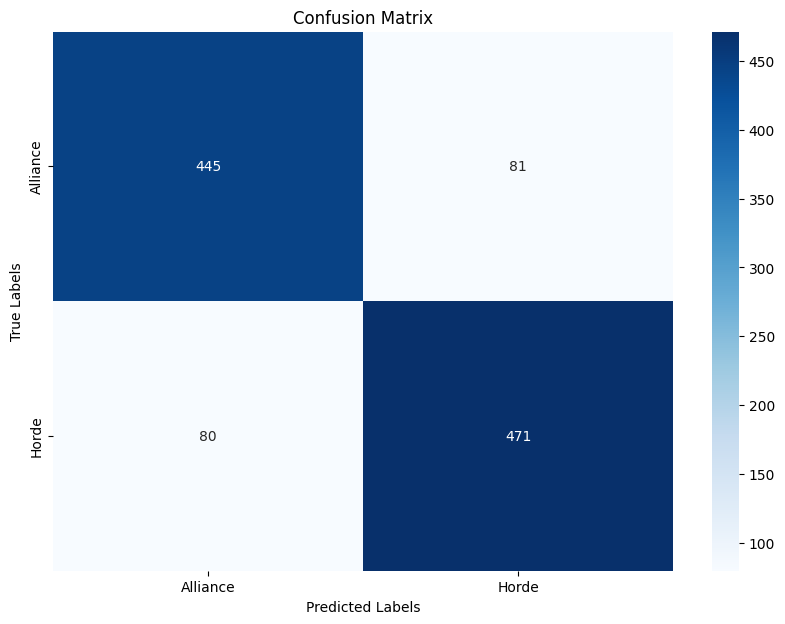

In [9]:
conf_matrix_dt = confusion_matrix(y_test_labels_dt, y_pred_test_labels_dt)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/faction_cm_dt.png')

plt.show()

In [10]:
param_grid_gradient_boosting = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 8, 64],     
    'max_features': [None, 'sqrt', 'log2'],
}

gradient_boosting = GradientBoostingClassifier()

random_search_gb = RandomizedSearchCV(gradient_boosting, param_grid_gradient_boosting, n_iter=50, cv=5, n_jobs=-1,
                                   verbose=1, random_state=42)

random_search_gb.fit(X_train, y_train_encoded)

y_pred_test_gb = random_search_gb.predict(X_test)
y_pred_train_gb = random_search_gb.predict(X_train)

y_test_labels_gb = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels_gb = label_encoder.inverse_transform(y_pred_test_gb)
y_train_labels_gb = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels_gb = label_encoder.inverse_transform(y_pred_train_gb)

accuracy_gb = accuracy_score(y_test_labels_gb, y_pred_test_labels_gb)

print("GradientBoostingClassifier best params:", random_search_gb.best_params_)
print("GradientBoostingClassifier accuracy:", accuracy_gb)
print("GradientBoostingClassifier best score:", random_search_gb.best_score_)
print("Classification Report for Test Data")
print(classification_report(y_test_labels_gb, y_pred_test_labels_gb))
print("Classification Report for Training Data")
print(classification_report(y_train_labels_gb, y_pred_train_labels_gb))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
GradientBoostingClassifier best params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': None}
GradientBoostingClassifier accuracy: 0.872794800371402
GradientBoostingClassifier best score: 0.8750621815134293
Classification Report for Test Data
              precision    recall  f1-score   support

    Alliance       0.89      0.85      0.87       526
       Horde       0.86      0.90      0.88       551

    accuracy                           0.87      1077
   macro avg       0.87      0.87      0.87      1077
weighted avg       0.87      0.87      0.87      1077

Classification Report for Training Data
              precision    recall  f1-score   support

    Alliance       1.00      1.00      1.00      2153
       Horde       1.00      1.00      1.00      2153

    accuracy                           1.00      4306
   macro avg       1.00      1.00      1.00      4306


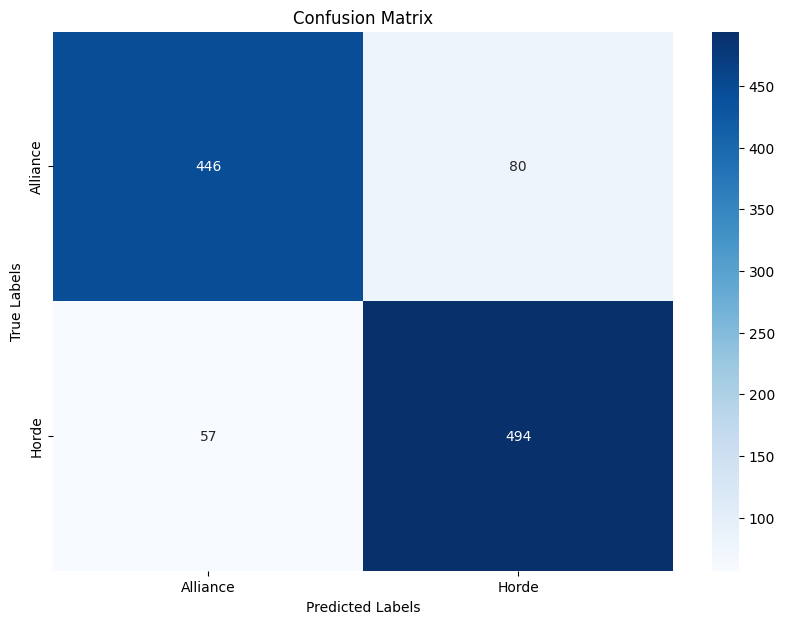

In [11]:
conf_matrix_gb = confusion_matrix(y_test_labels_gb, y_pred_test_labels_gb)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/faction_cm_gb.png')

plt.show()

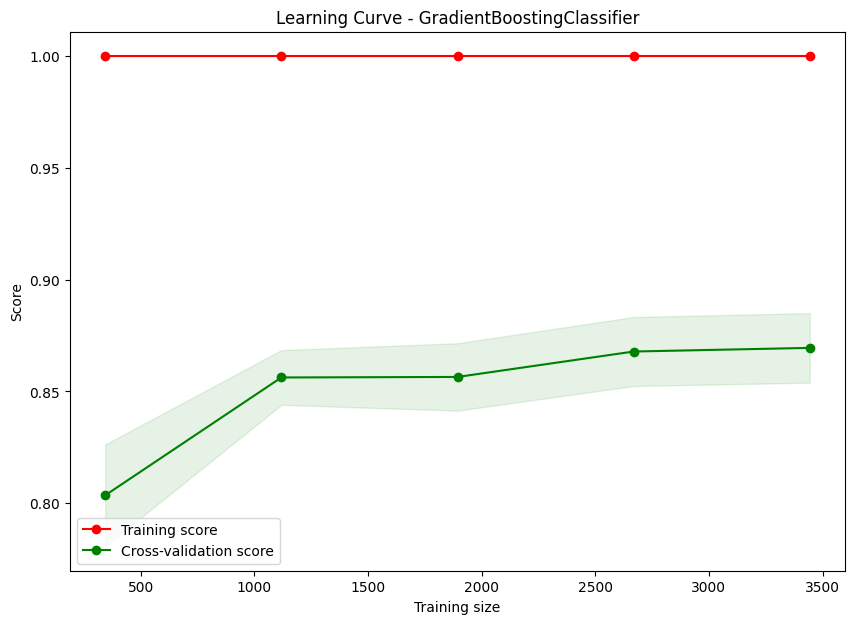

In [12]:
train_sizes, train_scores, test_scores = learning_curve(random_search_gb.best_estimator_, X_train, y_train_encoded, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.xlabel('Training size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve - GradientBoostingClassifier')
plt.savefig('images/faction_gb_learning.png')
plt.show()

In [13]:
param_grid_random_forest = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 8, 64],     
    'max_features': [None, 'sqrt', 'log2'],
}
random_forest = RandomForestClassifier()

random_search_rf = RandomizedSearchCV(random_forest, param_grid_random_forest, n_iter=50, cv=5, n_jobs=-1,
                                   verbose=1, random_state=42)

random_search_rf.fit(X_train, y_train_encoded)

y_pred_test_rf = random_search_rf.predict(X_test)
y_pred_train_rf = random_search_rf.predict(X_train)

y_test_labels_rf = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels_rf = label_encoder.inverse_transform(y_pred_test_rf)
y_train_labels_rf = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels_rf = label_encoder.inverse_transform(y_pred_train_rf)

accuracy_rf = accuracy_score(y_test_labels_rf, y_pred_test_labels_rf)

print("RandomForestClassifier best params:", random_search_rf.best_params_)
print("RandomForestClassifier accuracy:", accuracy_rf)
print("RandomForestClassifier best score:", random_search_rf.best_score_)
print("Classification Report for Test Data")
print(classification_report(y_test_labels_rf, y_pred_test_labels_rf))
print("Classification Report for Training Data")
print(classification_report(y_train_labels_rf, y_pred_train_labels_rf))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomForestClassifier best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
RandomForestClassifier accuracy: 0.8811513463324049
RandomForestClassifier best score: 0.8697187482315659
Classification Report for Test Data
              precision    recall  f1-score   support

    Alliance       0.90      0.85      0.88       526
       Horde       0.87      0.91      0.89       551

    accuracy                           0.88      1077
   macro avg       0.88      0.88      0.88      1077
weighted avg       0.88      0.88      0.88      1077

Classification Report for Training Data
              precision    recall  f1-score   support

    Alliance       1.00      0.99      0.99      2153
       Horde       0.99      1.00      0.99      2153

    accuracy                           0.99      4306
   macro avg       0.99      0.99      0.99      4306
weighted av

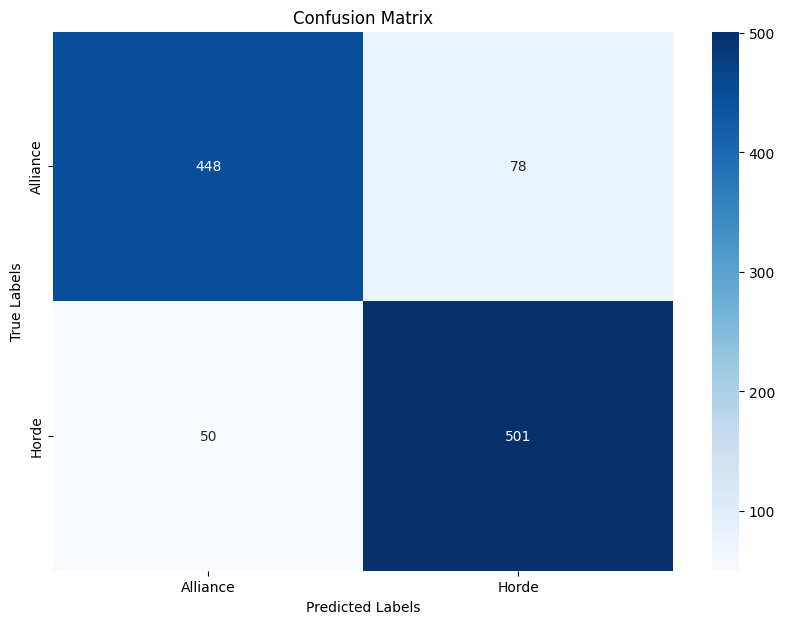

In [14]:
conf_matrix_rf = confusion_matrix(y_test_labels_rf, y_pred_test_labels_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/faction_cm_rf.png')

plt.show()

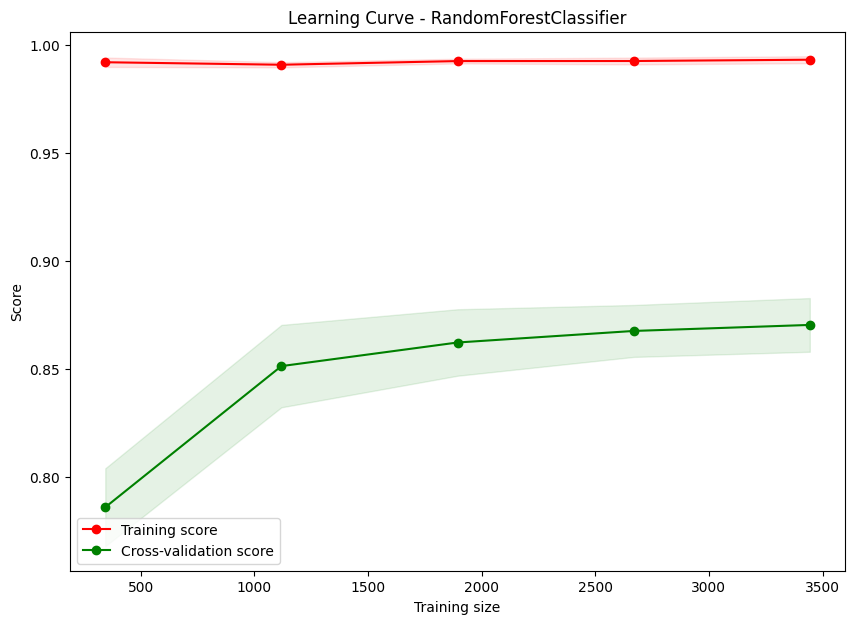

In [15]:
train_sizes, train_scores, test_scores = learning_curve(random_search_rf.best_estimator_, X_train, y_train_encoded, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.xlabel('Training size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve - RandomForestClassifier')
plt.savefig('images/faction_rf_learning.png')
plt.show()

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('neurons', min_value=1, max_value=10, step=1),
                    kernel_initializer=hp.Choice('init', values=['glorot_uniform', 'he_normal']),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(len(label_encoder.classes_), kernel_initializer='glorot_uniform', activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=hp.Choice('optimizer', values=['adam', 'SGD']),
                  metrics=['accuracy'])
    return model
    
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=10,
                        executions_per_trial=3,
                        directory='keras_tuner_dir',
                        project_name='my_project')

tuner.search(X_train_scaled, y_train_categorical, epochs=500, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = build_model(best_hps)

epochs = best_hps.get('epochs') if 'epochs' in best_hps.values else 500
batch_size = best_hps.get('batch_size') if 'batch_size' in best_hps.values else 10

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(X_train_scaled, y_train_categorical, epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2, callbacks=[early_stopping])

y_pred_test_encoded = model.predict(X_test_scaled)
y_pred_train_encoded = model.predict(X_train_scaled)

y_pred_test_num = np.argmax(y_pred_test_encoded, axis=1)
y_pred_train_num = np.argmax(y_pred_train_encoded, axis=1)

y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test_num)
y_train_labels = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels = label_encoder.inverse_transform(y_pred_train_num)

accuracy = accuracy_score(y_test_labels, y_pred_test_labels)

print("Best parameters found: ", best_hps.values)
print("Test accuracy: ", accuracy)
print("Classification Report for Test Data")
print(classification_report(y_test_labels, y_pred_test_labels))
print("Classification Report for Training Data")
print(classification_report(y_train_labels, y_pred_train_labels))

Reloading Tuner from keras_tuner_dir\my_project\tuner0.json
Epoch 1/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4545 - loss: 0.8210 - val_accuracy: 0.5916 - val_loss: 0.6450
Epoch 2/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5901 - loss: 0.6462 - val_accuracy: 0.6856 - val_loss: 0.5802
Epoch 3/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6711 - loss: 0.5917 - val_accuracy: 0.7285 - val_loss: 0.5426
Epoch 4/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6998 - loss: 0.5652 - val_accuracy: 0.7529 - val_loss: 0.5115
Epoch 5/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7249 - loss: 0.5348 - val_accuracy: 0.7633 - val_loss: 0.4824
Epoch 6/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7532 - loss: 0.5052 - val_accuracy: 0.7877 - val_loss: 0.4675
Epoch 7/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7653 - loss: 0.5016 - val_accuracy: 0.7981 - val_loss: 0.4540
Epoch 8/500
345/345 ━━━━━━━━━━━━━━━━━

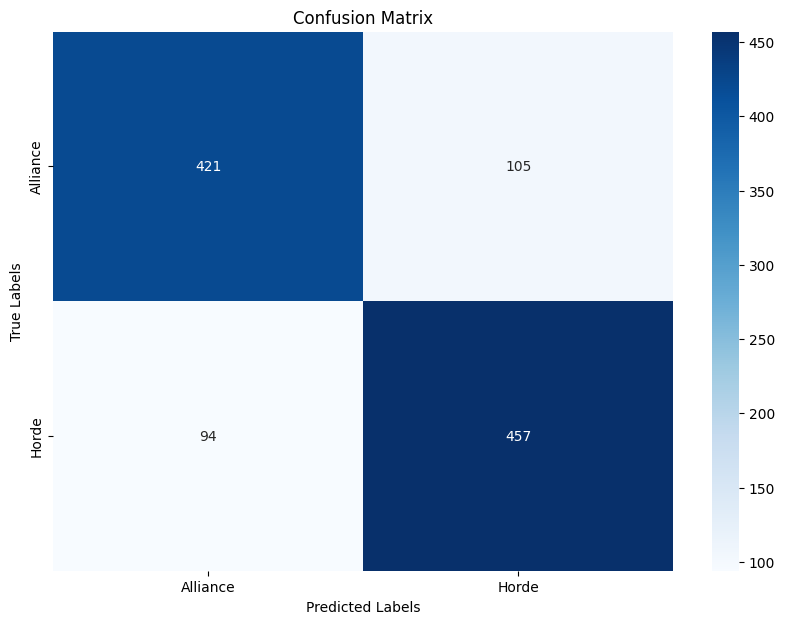

In [17]:
conf_matrix = confusion_matrix(y_test_labels, y_pred_test_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/faction_cm_nw.png')

plt.show()

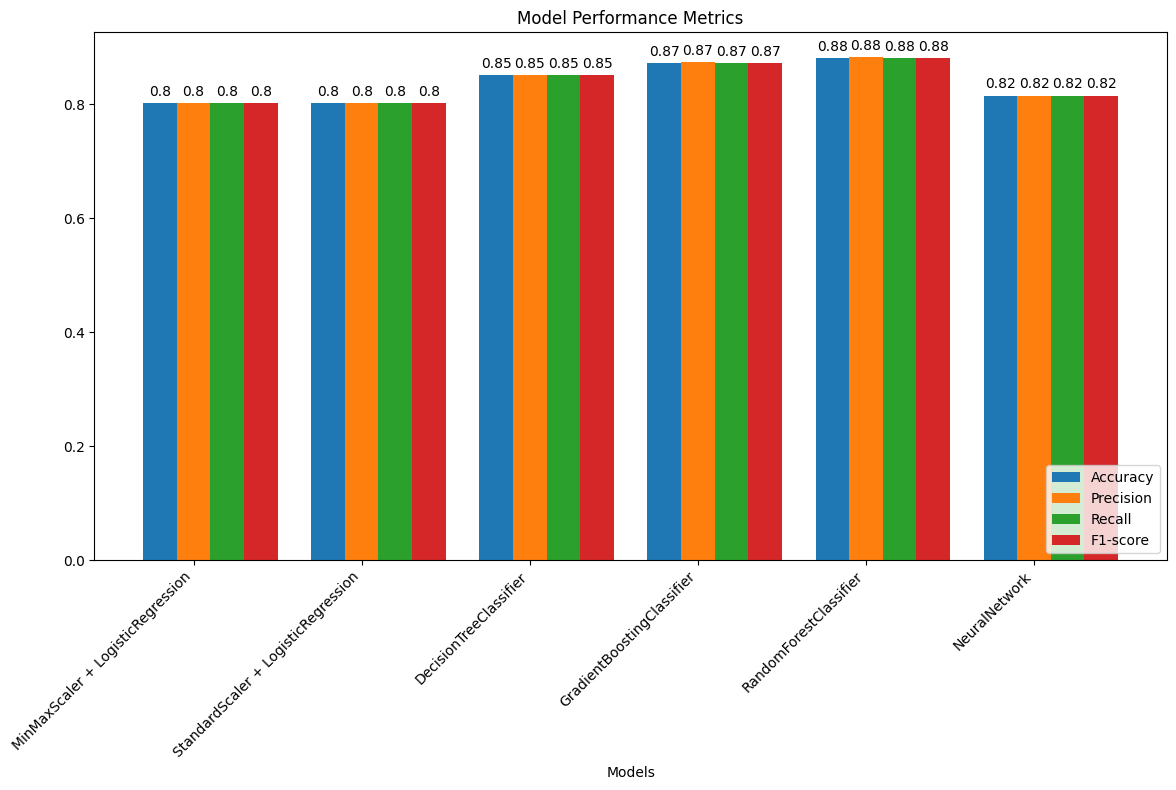

In [18]:
models = {
    "MinMaxScaler + LogisticRegression": {
        "best_params": random_search_minmax.best_params_,
        "accuracy": accuracy_minmax,
        "classification_report": classification_report(y_test_labels_minmax, y_pred_test_labels_minmax, output_dict=True)
    },
    "StandardScaler + LogisticRegression": {
        "best_params": random_search_standard.best_params_,
        "accuracy": accuracy_standard,
        "classification_report": classification_report(y_test_labels_standard, y_pred_test_labels_standard, output_dict=True)
    },
    "DecisionTreeClassifier": {
        "best_params": random_search_dt.best_params_,
        "accuracy": accuracy_dt,
        "classification_report": classification_report(y_test_labels_dt, y_pred_test_labels_dt, output_dict=True)
    },
    "GradientBoostingClassifier": {
        "best_params": random_search_gb.best_params_,
        "accuracy": accuracy_gb,
        "classification_report": classification_report(y_test_labels_gb, y_pred_test_labels_gb, output_dict=True)
    },
    "RandomForestClassifier": {
        "best_params": random_search_rf.best_params_,
        "accuracy": accuracy_rf,
        "classification_report": classification_report(y_test_labels_rf, y_pred_test_labels_rf, output_dict=True)
    },
    "NeuralNetwork": {
        "best_params": best_hps.values,
        "accuracy": accuracy,
        "classification_report": classification_report(y_test_labels, y_pred_test_labels, output_dict=True)
    }
}

model_names = list(models.keys())
accuracies = [models[model]["accuracy"] for model in model_names]
precision_scores = [models[model]["classification_report"]["weighted avg"]["precision"] for model in model_names]
recall_scores = [models[model]["classification_report"]["weighted avg"]["recall"] for model in model_names]
f1_scores = [models[model]["classification_report"]["weighted avg"]["f1-score"] for model in model_names]

x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x, precision_scores, width, label='Precision')
rects3 = ax.bar(x + width, recall_scores, width, label='Recall')
rects4 = ax.bar(x + 2*width, f1_scores, width, label='F1-score')

ax.set_xlabel('Models')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.legend(loc='lower right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.savefig('images/faction_summary.png')

plt.show()

In [19]:
def best_feature(X_train, X_test, y_train, y_test, model, top_features=10):
    features = {}

    for i, column_name in enumerate(X_train.columns):
        X_train_feature = np.array(X_train[column_name]).reshape(-1, 1)
        X_test_feature = np.array(X_test[column_name]).reshape(-1, 1)

        model.fit(X_train_feature, y_train)
        y_pred = model.predict(X_test_feature)

        accuracy = np.round(accuracy_score(y_test, y_pred), 3)
        features[column_name] = accuracy

    acc_df = pd.DataFrame(columns=['Feature', 'Accuracy'])
    for j in range(top_features):
        max_value = max(features.values())
        max_key = max(features, key=features.get)

        acc_df.loc[len(acc_df)] = [max_key, max_value]

        features.pop(max_key)

    return acc_df

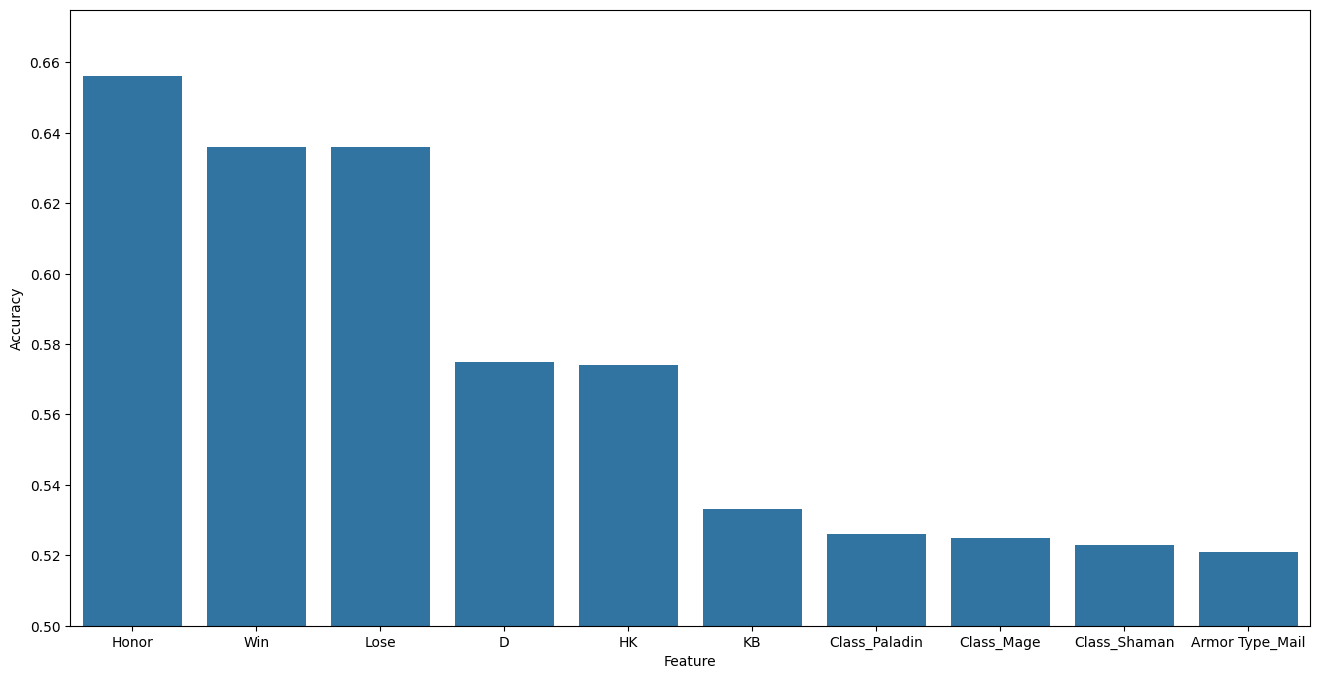

In [20]:
accuracy_df = best_feature(X_train, X_test, y_train, y_test, RandomForestClassifier(max_depth = None), top_features=10)
plt.figure(figsize=(16, 8))
sns.barplot(x ='Feature', y ='Accuracy', data = accuracy_df)

plt.ylim(0.5, 0.675)

plt.savefig('images/faction_best_feature.png')

plt.show()

In [21]:
X = df.drop('HK', axis=1)
y = df['HK']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_columns = ['Faction', 'Class', 'Rol', 'Class Type', 'Armor Type']

encoder = OneHotEncoder(handle_unknown='ignore')

X_train_encoded = encoder.fit_transform(X_train[categorical_columns])

X_test_encoded = encoder.transform(X_test[categorical_columns])

X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

X_train.drop(categorical_columns, axis=1, inplace=True)
X_test.drop(categorical_columns, axis=1, inplace=True)

X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded_df], axis=1)

In [22]:
pipeline_minmax = make_pipeline(MinMaxScaler(), LinearRegression())
param_grid_minmax = {
    'linearregression__fit_intercept': [True, False],
}
random_search_minmax = RandomizedSearchCV(pipeline_minmax, param_grid_minmax, cv=5, n_jobs=-1, 
                                          scoring='neg_mean_squared_error', n_iter=2, random_state=42)

random_search_minmax.fit(X_train, y_train)
y_pred_minmax = random_search_minmax.predict(X_test)

mse_minmax = mean_squared_error(y_test, y_pred_minmax)
mae_minmax = mean_absolute_error(y_test, y_pred_minmax)
rmse_minmax = np.sqrt(mse_minmax)
r2_minmax = r2_score(y_test, y_pred_minmax)

print("MinMaxScaler best params:", random_search_minmax.best_params_)
print("MinMaxScaler MSE:", mse_minmax)
print("MinMaxScaler MAE:", mae_minmax)
print("Root Mean Squared Error (RMSE):", rmse_minmax)
print("MinMaxScaler R^2 score:", r2_minmax)
print("MinMaxScaler best score:", -random_search_minmax.best_score_)

MinMaxScaler best params: {'linearregression__fit_intercept': False}
MinMaxScaler MSE: 132.12008973394376
MinMaxScaler MAE: 8.748709250957521
Root Mean Squared Error (RMSE): 11.494350339794927
MinMaxScaler R^2 score: 0.5084235663412235
MinMaxScaler best score: 125.20698130077899


In [23]:
pipeline_standard = make_pipeline(StandardScaler(), LinearRegression())
param_grid_standard = {
    'linearregression__fit_intercept': [True, False],
}
random_search_standard = RandomizedSearchCV(pipeline_standard, param_grid_standard, cv=5, n_jobs=-1, 
                                          scoring='neg_mean_squared_error', n_iter=2, random_state=42)

random_search_standard.fit(X_train, y_train)
y_pred_standard = random_search_standard.predict(X_test)

mse_standard = mean_squared_error(y_test, y_pred_standard)
mae_standard = mean_absolute_error(y_test, y_pred_standard)
rmse_standard = np.sqrt(mse_standard)
r2_standard = r2_score(y_test, y_pred_standard)

print("StandardScaler best params:", random_search_standard.best_params_)
print("StandardScaler MSE:", mse_standard)
print("StandardScaler MAE:", mae_standard)
print("Root Mean Squared Error (RMSE):", rmse_standard)
print("StandardScaler R^2 score:", r2_standard)
print("StandardScaler best score:", -random_search_standard.best_score_)

StandardScaler best params: {'linearregression__fit_intercept': True}
StandardScaler MSE: 131.9791827398099
StandardScaler MAE: 8.753026291253137
Root Mean Squared Error (RMSE): 11.488219302390162
StandardScaler R^2 score: 0.5089478360249134
StandardScaler best score: 125.27399707333987


In [24]:
param_grid_decision_tree = {
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 8, 64],
    'max_features': [None, 'sqrt', 'log2'],
}

decision_tree = DecisionTreeRegressor()

random_search_dt = RandomizedSearchCV(decision_tree, param_grid_decision_tree, cv=5, n_jobs=-1, 
                                      scoring='neg_mean_squared_error', n_iter=50, random_state=42)

random_search_dt.fit(X_train, y_train)

y_pred_dt = random_search_dt.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("DecisionTreeRegressor best params:", random_search_dt.best_params_)
print("DecisionTreeRegressor MSE:", mse_dt)
print("DecisionTreeRegressor MAE:", mae_dt)
print("Root Mean Squared Error (RMSE):", rmse_dt)
print("DecisionTreeRegressor R^2 score:", r2_dt)
print("DecisionTreeRegressor best score:", random_search_dt.best_score_)

DecisionTreeRegressor best params: {'min_samples_split': 10, 'min_samples_leaf': 64, 'max_features': None, 'max_depth': 20}
DecisionTreeRegressor MSE: 124.30865331267562
DecisionTreeRegressor MAE: 8.307188981264884
Root Mean Squared Error (RMSE): 11.149379055027039
DecisionTreeRegressor R^2 score: 0.5374874132206184
DecisionTreeRegressor best score: -124.78961406742732


In [25]:
param_grid_gradient_boosting = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 8, 64],     
    'max_features': [None, 'sqrt', 'log2'],
}

gradient_boosting = GradientBoostingRegressor()

random_search_gb = RandomizedSearchCV(gradient_boosting, param_grid_gradient_boosting, cv=5, n_jobs=-1, 
                                      scoring='neg_mean_squared_error', n_iter=50, random_state=42)

random_search_gb.fit(X_train, y_train)

y_pred_gb = random_search_gb.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("GradientBoostingRegressor best params:", random_search_gb.best_params_)
print("GradientBoostingRegressor MSE:", mse_gb)
print("GradientBoostingRegressor MAE:", mae_gb)
print("Root Mean Squared Error (RMSE):", rmse_gb)
print("GradientBoostingRegressor R^2 score:", r2_gb)
print("GradientBoostingRegressor best score:", random_search_gb.best_score_)

GradientBoostingRegressor best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 64, 'max_features': None, 'max_depth': 10}
GradientBoostingRegressor MSE: 96.2199913277969
GradientBoostingRegressor MAE: 7.159475283123502
Root Mean Squared Error (RMSE): 9.809178932397803
GradientBoostingRegressor R^2 score: 0.6419963059452508
GradientBoostingRegressor best score: -94.67855794755728


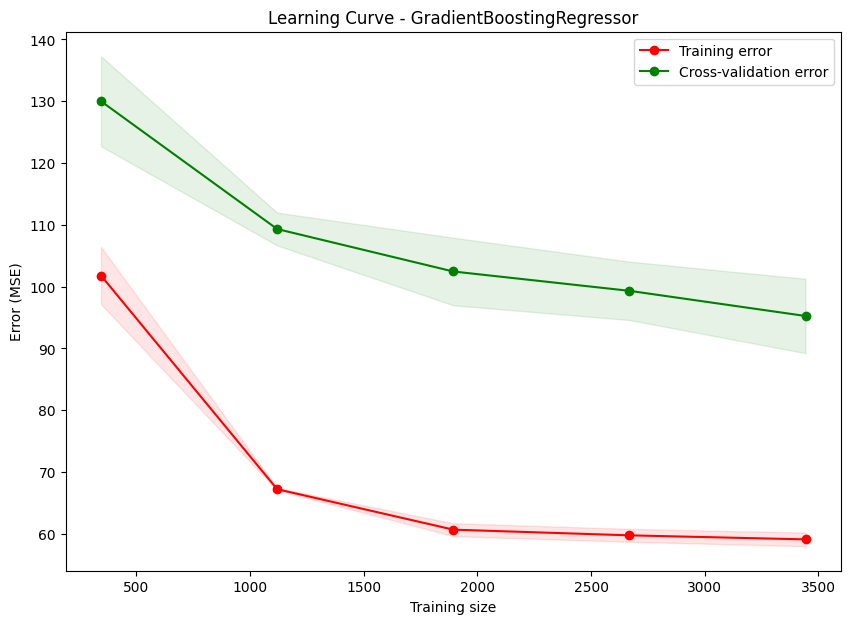

In [26]:
train_sizes, train_scores, test_scores = learning_curve(random_search_gb.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_mean_squared_error')

train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.xlabel('Training size')
plt.ylabel('Error (MSE)')
plt.legend(loc='best')
plt.title('Learning Curve - GradientBoostingRegressor')
plt.savefig('images/hk_gb_learnig.png')
plt.show()

In [27]:
param_grid_random_forest = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 8, 64],     
    'max_features': [None, 'sqrt', 'log2'],
}
random_forest = RandomForestRegressor()

random_search_rf = RandomizedSearchCV(random_forest, param_grid_random_forest, cv=5, n_jobs=-1, 
                                      scoring='neg_mean_squared_error', n_iter=50, random_state=42)

random_search_rf.fit(X_train, y_train)

y_pred_rf = random_search_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("RandomForestRegressor best params:", random_search_rf.best_params_)
print("RandomForestRegressor MSE:", mse_rf)
print("RandomForestRegressor MAE:", mae_rf)
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("RandomForestRegressor R^2 score:", r2_rf)
print("RandomForestRegressor best score:", random_search_rf.best_score_)

RandomForestRegressor best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
RandomForestRegressor MSE: 101.80603185409099
RandomForestRegressor MAE: 7.340136447376001
Root Mean Squared Error (RMSE): 10.08989751454845
RandomForestRegressor R^2 score: 0.6212124426757153
RandomForestRegressor best score: -99.33323547929926


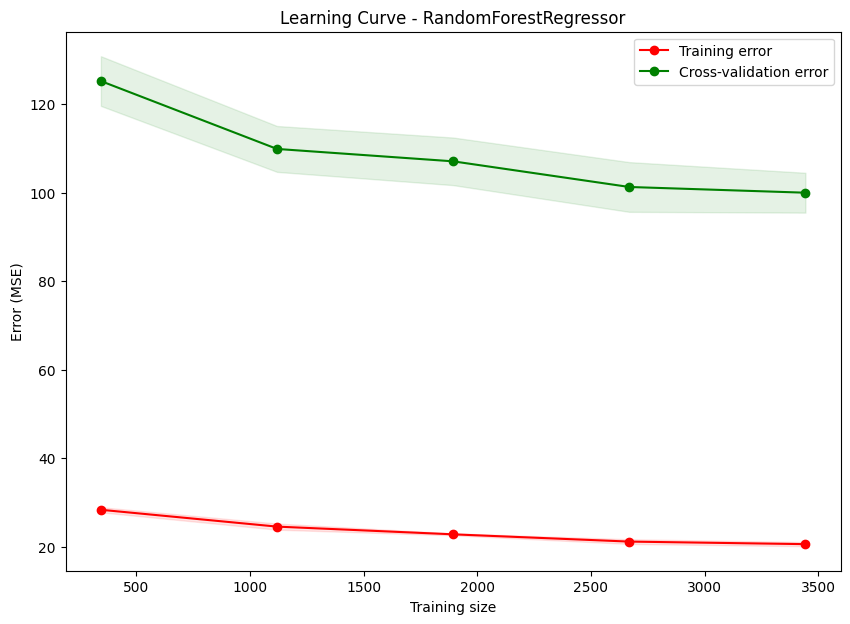

In [28]:
train_sizes, train_scores, test_scores = learning_curve(random_search_rf.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_mean_squared_error')

train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.xlabel('Training size')
plt.ylabel('Error (MSE)')
plt.legend(loc='best')
plt.title('Learning Curve - RandomForestRegressor')
plt.savefig('images/hk_rf_learnig.png')
plt.show()

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('neurons', min_value=1, max_value=10, step=1),
                    kernel_initializer=hp.Choice('init', values=['glorot_uniform', 'he_normal']),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='linear'))
    model.compile(loss='mean_squared_error',
                  optimizer=hp.Choice('optimizer', values=['adam', 'SGD']),
                  metrics=['mean_squared_error'])
    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_mean_squared_error',
                        max_trials=10,
                        executions_per_trial=3,
                        directory='keras_tuner_dir',
                        project_name='my_regression_project')

tuner.search(X_train_scaled, y_train, epochs=500, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = build_model(best_hps)

epochs = best_hps.get('epochs') if 'epochs' in best_hps.values else 500
batch_size = best_hps.get('batch_size') if 'batch_size' in best_hps.values else 10

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)

mse_s = mean_squared_error(y_test, y_pred)
mae_s = mean_absolute_error(y_test, y_pred)
rmse_s = np.sqrt(mse_s)
r2_s = r2_score(y_test, y_pred)

print("Best parameters found: ", best_hps.values)
print("Mean Squared Error (MSE): ", mse_s)
print("Mean Absolute Error (MAE): ", mae_s)
print("Root Mean Squared Error (RMSE): ", rmse_s)
print("R^2 score: ", r2_s)

Reloading Tuner from keras_tuner_dir\my_regression_project\tuner0.json
Epoch 1/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 931.8386 - mean_squared_error: 931.8386 - val_loss: 695.4875 - val_mean_squared_error: 695.4875
Epoch 2/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 657.3815 - mean_squared_error: 657.3815 - val_loss: 392.5614 - val_mean_squared_error: 392.5614
Epoch 3/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 383.9070 - mean_squared_error: 383.9070 - val_loss: 219.3690 - val_mean_squared_error: 219.3690
Epoch 4/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 250.5254 - mean_squared_error: 250.5254 - val_loss: 167.4753 - val_mean_squared_error: 167.4753
Epoch 5/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 218.8914 - mean_squared_error: 218.8914 - val_loss: 150.5081 - val_mean_squared_error: 150.5080
Epoch 6/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 214.0549 - mean_squared_error: 214.0549 - val_loss: 143.0396 - val_mean_squared_err

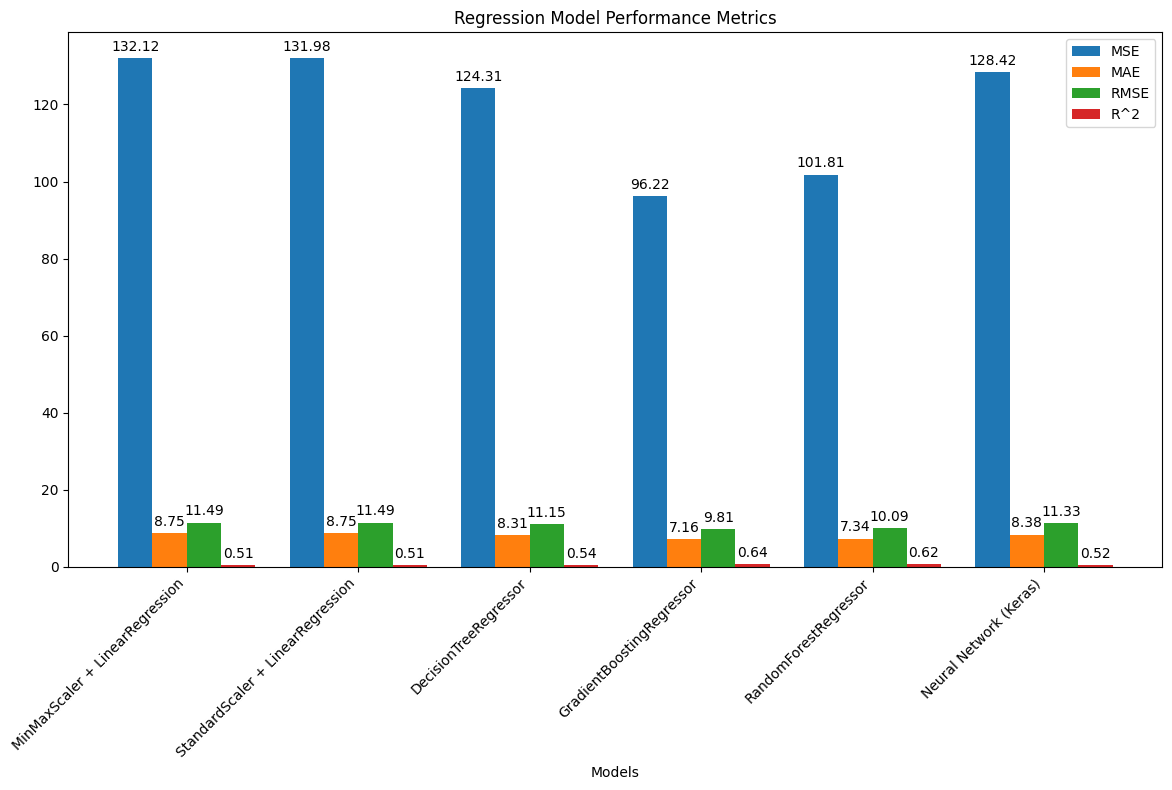

In [30]:
models_regression = {
    "MinMaxScaler + LinearRegression": {
        "best_params": random_search_minmax.best_params_,
        "mse": mse_minmax,
        "mae": mae_minmax,
        "rmse": rmse_minmax,
        "r2": r2_minmax
    },
    "StandardScaler + LinearRegression": {
        "best_params": random_search_standard.best_params_,
        "mse": mse_standard,
        "mae": mae_standard,
        "rmse": rmse_standard,
        "r2": r2_standard
    },
    "DecisionTreeRegressor": {
        "best_params": random_search_dt.best_params_,
        "mse": mse_dt,
        "mae": mae_dt,
        "rmse": rmse_dt,
        "r2": r2_dt
    },
    "GradientBoostingRegressor": {
        "best_params": random_search_gb.best_params_,
        "mse": mse_gb,
        "mae": mae_gb,
        "rmse": rmse_gb,
        "r2": r2_gb
    },
    "RandomForestRegressor": {
        "best_params": random_search_rf.best_params_,
        "mse": mse_rf,
        "mae": mae_rf,
        "rmse": rmse_rf,
        "r2": r2_rf
    },
    "Neural Network (Keras)": {
        "best_params": best_hps.values,
        "mse": mse_s,
        "mae": mae_s,
        "rmse": rmse_s,
        "r2": r2_s
    }
}

model_names_regression = list(models_regression.keys())
mse_values = [models_regression[model]["mse"] for model in model_names_regression]
mae_values = [models_regression[model]["mae"] for model in model_names_regression]
rmse_values = [models_regression[model]["rmse"] for model in model_names_regression]
r2_values = [models_regression[model]["r2"] for model in model_names_regression]

x = np.arange(len(model_names_regression))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - 1.5*width, mse_values, width, label='MSE')
rects2 = ax.bar(x - 0.5*width, mae_values, width, label='MAE')
rects3 = ax.bar(x + 0.5*width, rmse_values, width, label='RMSE')
rects4 = ax.bar(x + 1.5*width, r2_values, width, label='R^2')

ax.set_xlabel('Models')
ax.set_title('Regression Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(model_names_regression, rotation=45, ha="right")
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.savefig('images/hk_summary.png')

plt.show()

In [31]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_columns = ['Faction', 'Rol', 'Class Type', 'Armor Type']
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

X_train.drop(categorical_columns, axis=1, inplace=True)
X_test.drop(categorical_columns, axis=1, inplace=True)

X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded_df], axis=1)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [32]:
pipeline_minmax = make_pipeline(MinMaxScaler(), LogisticRegression())
param_grid_minmax = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'logisticregression__max_iter': [1000, 2000, 3000],
    'logisticregression__class_weight': [None, 'balanced'],
}
random_search_minmax = RandomizedSearchCV(pipeline_minmax, param_grid_minmax, n_iter=50, cv=5, n_jobs=-1, 
                                          verbose=1, random_state=42)

random_search_minmax.fit(X_train, y_train_encoded)
y_pred_test_minmax = random_search_minmax.predict(X_test)
y_pred_train_minmax = random_search_minmax.predict(X_train)

y_test_labels_minmax = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels_minmax = label_encoder.inverse_transform(y_pred_test_minmax)
y_train_labels_minmax = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels_minmax = label_encoder.inverse_transform(y_pred_train_minmax)

accuracy_minmax = accuracy_score(y_test_labels_minmax, y_pred_test_labels_minmax)

print("MinMaxScaler best params:", random_search_minmax.best_params_)
print("MinMaxScaler accuracy:", accuracy_minmax)
print("MinMaxScaler best score:", random_search_minmax.best_score_)
print("Classification Report for Test Data")
print(classification_report(y_test_labels_minmax, y_pred_test_labels_minmax))
print("Classification Report for Training Data")
print(classification_report(y_train_labels_minmax, y_pred_train_labels_minmax))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
MinMaxScaler best params: {'logisticregression__solver': 'newton-cg', 'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 2000, 'logisticregression__class_weight': None, 'logisticregression__C': 10}
MinMaxScaler accuracy: 0.8579387186629527
MinMaxScaler best score: 0.8625194359335042
Classification Report for Test Data
              precision    recall  f1-score   support

Death Knight       1.00      1.00      1.00        73
Demon Hunter       0.57      0.54      0.56        74
       Druid       0.68      0.91      0.78        99
      Hunter       1.00      1.00      1.00       100
        Mage       0.76      0.97      0.85       110
        Monk       0.40      0.12      0.19        49
     Paladin       1.00      1.00      1.00        91
      Priest       0.96      0.69      0.80       109
       Rogue       0.63      0.66      0.64        87
      Shaman       1.00      1.00      1.00       117
     

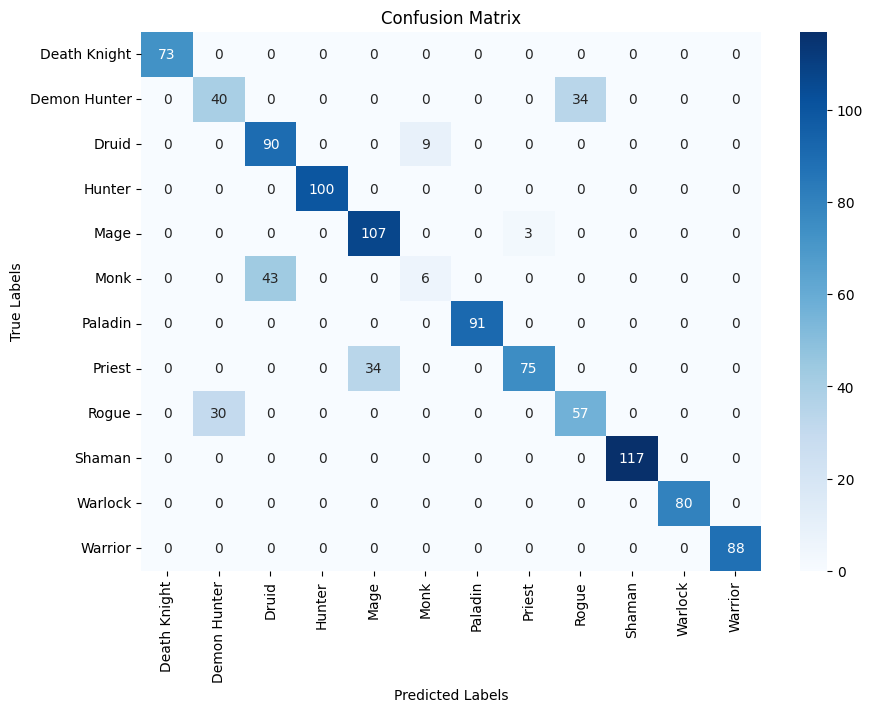

In [33]:
conf_matrix_minmax = confusion_matrix(y_test_labels_minmax, y_pred_test_labels_minmax)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_minmax, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/class_cm_minmax.png')

plt.show()

In [34]:
pipeline_standard = make_pipeline(StandardScaler(), LogisticRegression())
param_grid_standard = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'logisticregression__max_iter': [1000, 2000, 3000],
    'logisticregression__class_weight': [None, 'balanced'],
}
random_search_standard = RandomizedSearchCV(pipeline_standard, param_grid_standard, n_iter=50, cv=5, n_jobs=-1, 
                                   verbose=1, random_state=42)

random_search_standard.fit(X_train, y_train_encoded)
y_pred_test_standard = random_search_standard.predict(X_test)
y_pred_train_standard = random_search_standard.predict(X_train)

y_test_labels_standard = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels_standard = label_encoder.inverse_transform(y_pred_test_standard)
y_train_labels_standard = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels_standard = label_encoder.inverse_transform(y_pred_train_standard)

accuracy_standard = accuracy_score(y_test_labels_standard, y_pred_test_labels_standard)

print("StandardScaler best params:", random_search_standard.best_params_)
print("StandardScaler accuracy:", accuracy_standard)
print("StandardScaler best score:", random_search_standard.best_score_)
print("Classification Report for Test Data")
print(classification_report(y_test_labels_standard, y_pred_test_labels_standard))
print("Classification Report for Training Data")
print(classification_report(y_train_labels_standard, y_pred_train_labels_standard))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
StandardScaler best params: {'logisticregression__solver': 'lbfgs', 'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 1000, 'logisticregression__class_weight': None, 'logisticregression__C': 10}
StandardScaler accuracy: 0.8597957288765088
StandardScaler best score: 0.8629829341051117
Classification Report for Test Data
              precision    recall  f1-score   support

Death Knight       1.00      1.00      1.00        73
Demon Hunter       0.58      0.55      0.57        74
       Druid       0.67      0.90      0.77        99
      Hunter       1.00      1.00      1.00       100
        Mage       0.79      0.94      0.85       110
        Monk       0.38      0.12      0.18        49
     Paladin       1.00      1.00      1.00        91
      Priest       0.92      0.74      0.82       109
       Rogue       0.63      0.66      0.64        87
      Shaman       1.00      1.00      1.00       117
   

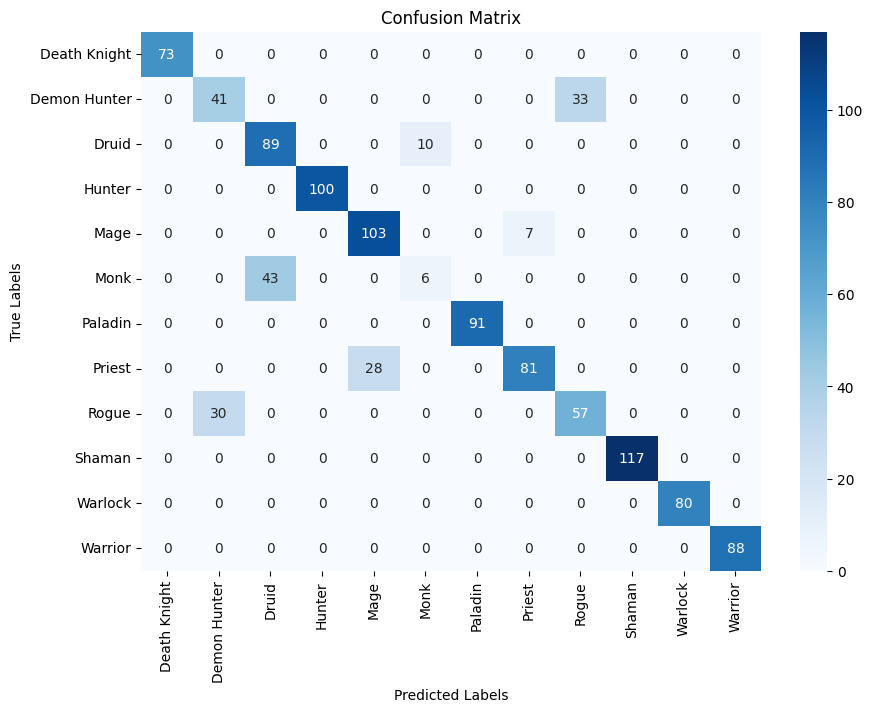

In [35]:
conf_matrix_standard = confusion_matrix(y_test_labels_standard, y_pred_test_labels_standard)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_standard, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/class_cm_standard.png')

plt.show()

In [36]:
param_grid_decision_tree = {
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 8, 64],
    'max_features': [None, 'sqrt', 'log2'],
}

decision_tree = DecisionTreeClassifier()

random_search_dt = RandomizedSearchCV(decision_tree, param_grid_decision_tree, n_iter=50, cv=5, n_jobs=-1, 
                                   verbose=1, random_state=42)

random_search_dt.fit(X_train, y_train_encoded)

y_pred_test_dt = random_search_dt.predict(X_test)
y_pred_train_dt = random_search_dt.predict(X_train)

y_test_labels_dt = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels_dt = label_encoder.inverse_transform(y_pred_test_dt)
y_train_labels_dt = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels_dt = label_encoder.inverse_transform(y_pred_train_dt)

accuracy_dt = accuracy_score(y_test_labels_dt, y_pred_test_labels_dt)

print("DecisionTreeClassifier best params:", random_search_dt.best_params_)
print("DecisionTreeClassifier accuracy:", accuracy_dt)
print("DecisionTreeClassifier best score:", random_search_dt.best_score_)
print("Classification Report for Test Data")
print(classification_report(y_test_labels_dt, y_pred_test_labels_dt))
print("Classification Report for Training Data")
print(classification_report(y_train_labels_dt, y_pred_train_labels_dt))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
DecisionTreeClassifier best params: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}
DecisionTreeClassifier accuracy: 0.8690807799442897
DecisionTreeClassifier best score: 0.8569456009442428
Classification Report for Test Data
              precision    recall  f1-score   support

Death Knight       1.00      1.00      1.00        73
Demon Hunter       0.67      0.59      0.63        74
       Druid       0.69      0.92      0.79        99
      Hunter       1.00      1.00      1.00       100
        Mage       0.74      0.96      0.84       110
        Monk       0.53      0.18      0.27        49
     Paladin       1.00      1.00      1.00        91
      Priest       0.95      0.66      0.78       109
       Rogue       0.68      0.75      0.71        87
      Shaman       1.00      1.00      1.00       117
     Warlock       1.00      1.00      1.00        80
     Warrior       1.00 

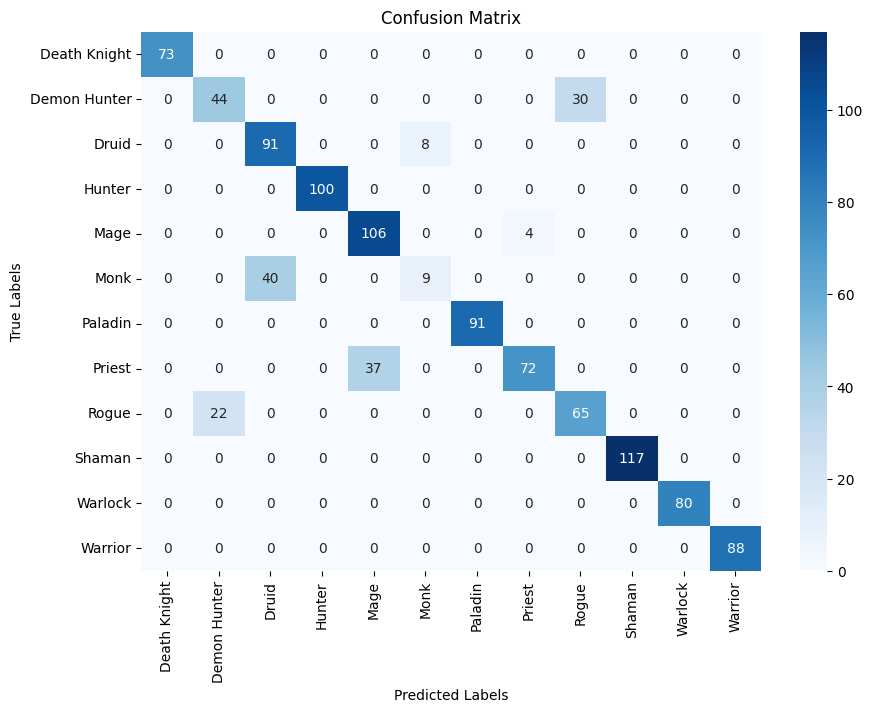

In [37]:
conf_matrix_dt = confusion_matrix(y_test_labels_dt, y_pred_test_labels_dt)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/class_cm_dt.png')

plt.show()

In [38]:
param_grid_gradient_boosting = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 8, 64],     
    'max_features': [None, 'sqrt', 'log2'],
}

gradient_boosting = GradientBoostingClassifier()

random_search_gb = RandomizedSearchCV(gradient_boosting, param_grid_gradient_boosting, n_iter=50, cv=5, n_jobs=-1,
                                   verbose=1, random_state=42)

random_search_gb.fit(X_train, y_train_encoded)

y_pred_test_gb = random_search_gb.predict(X_test)
y_pred_train_gb = random_search_gb.predict(X_train)

y_test_labels_gb = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels_gb = label_encoder.inverse_transform(y_pred_test_gb)
y_train_labels_gb = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels_gb = label_encoder.inverse_transform(y_pred_train_gb)

accuracy_gb = accuracy_score(y_test_labels_gb, y_pred_test_labels_gb)

print("GradientBoostingClassifier best params:", random_search_gb.best_params_)
print("GradientBoostingClassifier accuracy:", accuracy_gb)
print("GradientBoostingClassifier best score:", random_search_gb.best_score_)
print("Classification Report for Test Data")
print(classification_report(y_test_labels_gb, y_pred_test_labels_gb))
print("Classification Report for Training Data")
print(classification_report(y_train_labels_gb, y_pred_train_labels_gb))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
GradientBoostingClassifier best params: {'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 64, 'max_features': None, 'max_depth': 20}
GradientBoostingClassifier accuracy: 0.851439182915506
GradientBoostingClassifier best score: 0.8643763928524271
Classification Report for Test Data
              precision    recall  f1-score   support

Death Knight       1.00      1.00      1.00        73
Demon Hunter       0.53      0.55      0.54        74
       Druid       0.68      0.90      0.77        99
      Hunter       1.00      1.00      1.00       100
        Mage       0.78      0.91      0.84       110
        Monk       0.41      0.14      0.21        49
     Paladin       1.00      1.00      1.00        91
      Priest       0.89      0.73      0.80       109
       Rogue       0.61      0.59      0.60        87
      Shaman       1.00      1.00      1.00       117
     Warlock       1.00      1.00      1.00  

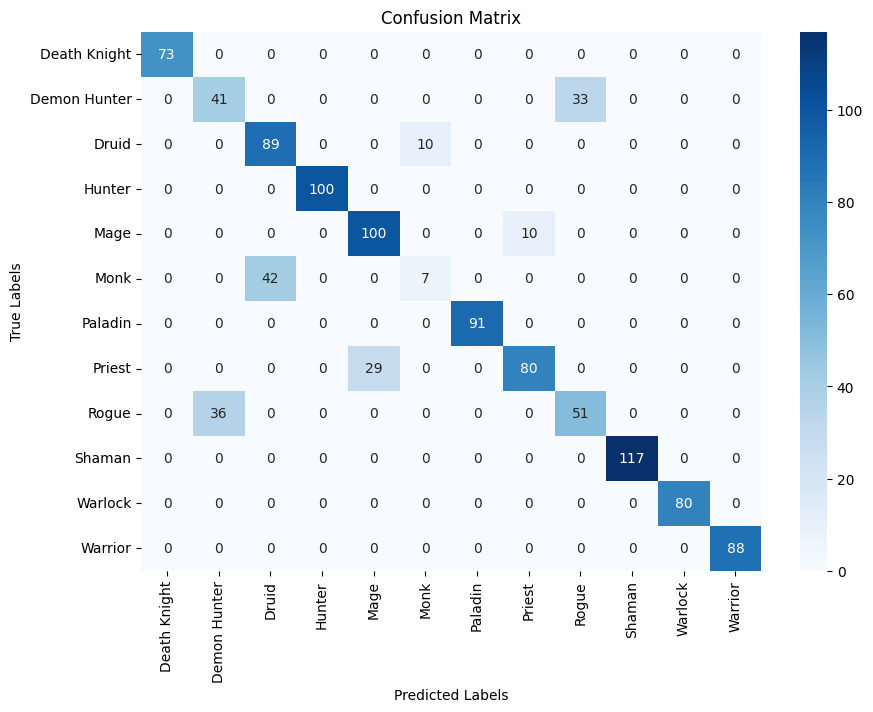

In [39]:
conf_matrix_gb = confusion_matrix(y_test_labels_gb, y_pred_test_labels_gb)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/class_cm_gb.png')

plt.show()

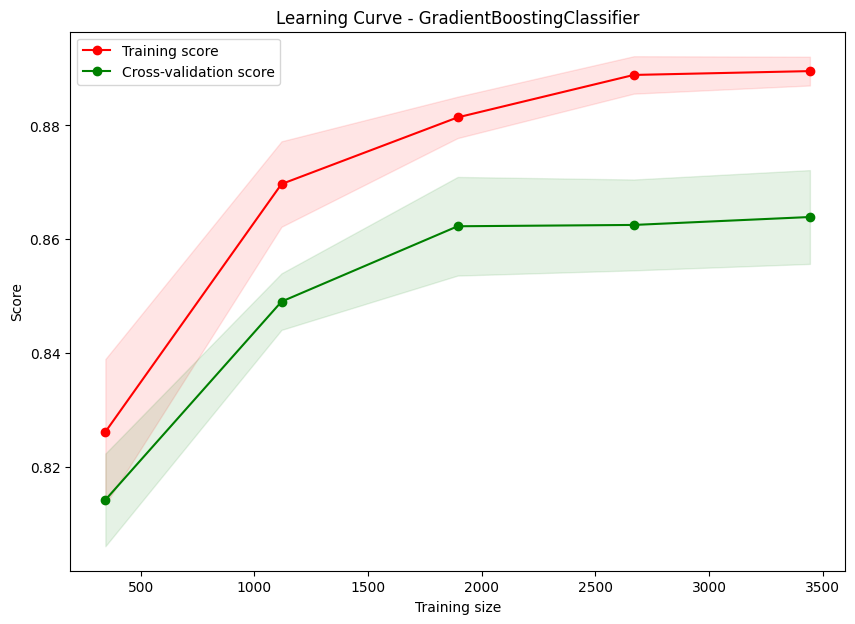

In [40]:
train_sizes, train_scores, test_scores = learning_curve(random_search_gb.best_estimator_, X_train, y_train_encoded, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.xlabel('Training size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve - GradientBoostingClassifier')
plt.savefig('images/class_gb_learning.png')
plt.show()

In [41]:
param_grid_random_forest = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 8, 64],     
    'max_features': [None, 'sqrt', 'log2'],
}
random_forest = RandomForestClassifier()

random_search_rf = RandomizedSearchCV(random_forest, param_grid_random_forest, n_iter=50, cv=5, n_jobs=-1,
                                   verbose=1, random_state=42)

random_search_rf.fit(X_train, y_train_encoded)

y_pred_test_rf = random_search_rf.predict(X_test)
y_pred_train_rf = random_search_rf.predict(X_train)

y_test_labels_rf = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels_rf = label_encoder.inverse_transform(y_pred_test_rf)
y_train_labels_rf = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels_rf = label_encoder.inverse_transform(y_pred_train_rf)

accuracy_rf = accuracy_score(y_test_labels_rf, y_pred_test_labels_rf)

print("RandomForestClassifier best params:", random_search_rf.best_params_)
print("RandomForestClassifier accuracy:", accuracy_rf)
print("RandomForestClassifier best score:", random_search_rf.best_score_)
print("Classification Report for Test Data")
print(classification_report(y_test_labels_rf, y_pred_test_labels_rf))
print("Classification Report for Training Data")
print(classification_report(y_train_labels_rf, y_pred_train_labels_rf))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomForestClassifier best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 20}
RandomForestClassifier accuracy: 0.8486536675951718
RandomForestClassifier best score: 0.8701808990247676
Classification Report for Test Data
              precision    recall  f1-score   support

Death Knight       1.00      1.00      1.00        73
Demon Hunter       0.56      0.50      0.53        74
       Druid       0.66      0.88      0.75        99
      Hunter       1.00      1.00      1.00       100
        Mage       0.78      0.89      0.83       110
        Monk       0.25      0.08      0.12        49
     Paladin       1.00      1.00      1.00        91
      Priest       0.87      0.74      0.80       109
       Rogue       0.61      0.67      0.64        87
      Shaman       1.00      1.00      1.00       117
     Warlock       1.00      1.00      1.00        80
   

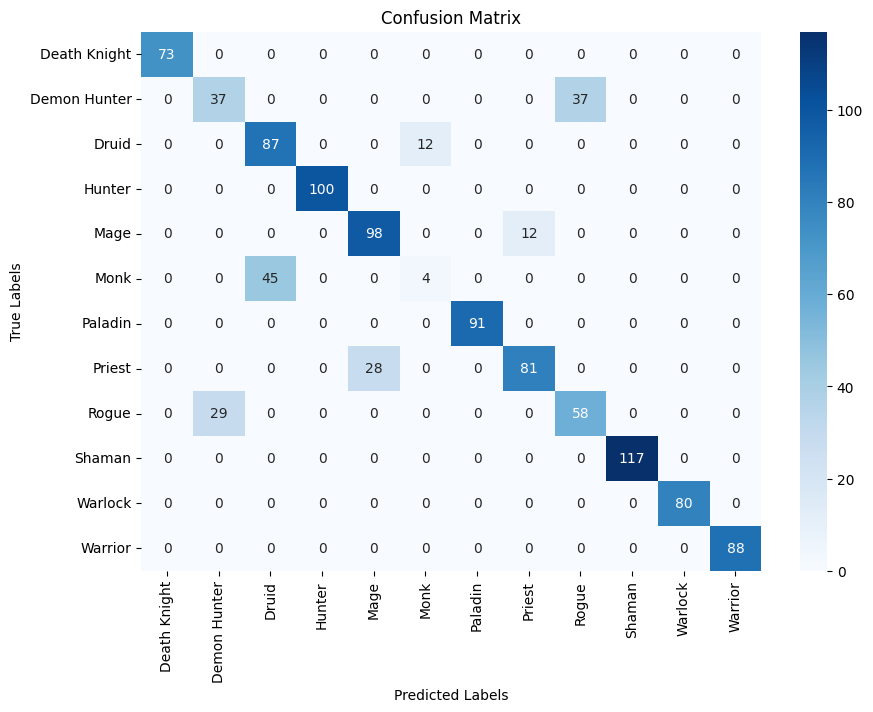

In [42]:
conf_matrix_rf = confusion_matrix(y_test_labels_rf, y_pred_test_labels_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('images/class_cm_rf.png')

plt.show()

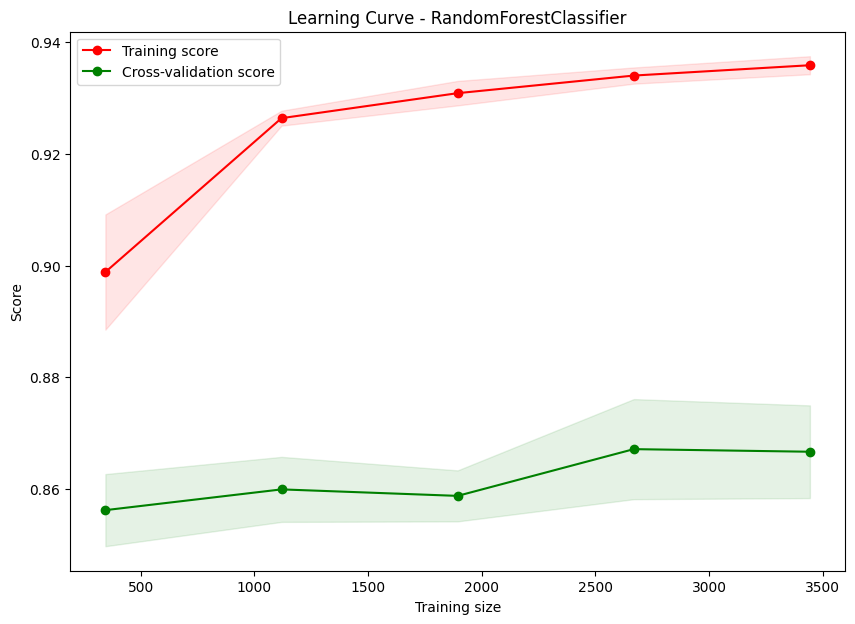

In [43]:
train_sizes, train_scores, test_scores = learning_curve(random_search_rf.best_estimator_, X_train, y_train_encoded, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.xlabel('Training size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve - RandomForestClassifier')
plt.savefig('images/class_rf_learning.png')
plt.show()

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('neurons', min_value=1, max_value=10, step=1),
                    kernel_initializer=hp.Choice('init', values=['glorot_uniform', 'he_normal']),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(len(label_encoder.classes_), kernel_initializer='glorot_uniform', activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=hp.Choice('optimizer', values=['adam', 'SGD']),
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=10,
                        executions_per_trial=3,
                        directory='keras_tuner_dir',
                        project_name='my_project')

tuner.search(X_train_scaled, y_train_categorical, epochs=500, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = build_model(best_hps)

epochs = best_hps.get('epochs') if 'epochs' in best_hps.values else 500
batch_size = best_hps.get('batch_size') if 'batch_size' in best_hps.values else 10

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(X_train_scaled, y_train_categorical, epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2, callbacks=[early_stopping])

y_pred_test_encoded = model.predict(X_test_scaled)
y_pred_train_encoded = model.predict(X_train_scaled)

y_pred_test_num = np.argmax(y_pred_test_encoded, axis=1)
y_pred_train_num = np.argmax(y_pred_train_encoded, axis=1)

y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test_num)
y_train_labels = label_encoder.inverse_transform(y_train_encoded)
y_pred_train_labels = label_encoder.inverse_transform(y_pred_train_num)

accuracy = accuracy_score(y_test_labels, y_pred_test_labels)

print("Best parameters found: ", best_hps.values)
print("Test accuracy: ", accuracy)
print("Classification Report for Test Data")
print(classification_report(y_test_labels, y_pred_test_labels, zero_division=0))
print("Classification Report for Training Data")
print(classification_report(y_train_labels, y_pred_train_labels, zero_division=0))

Reloading Tuner from keras_tuner_dir\my_project\tuner0.json
Epoch 1/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1328 - loss: 2.4710 - val_accuracy: 0.4269 - val_loss: 1.7945
Epoch 2/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4507 - loss: 1.7355 - val_accuracy: 0.7587 - val_loss: 1.0881
Epoch 3/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6968 - loss: 1.0697 - val_accuracy: 0.8445 - val_loss: 0.6248
Epoch 4/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7674 - loss: 0.6983 - val_accuracy: 0.8538 - val_loss: 0.4450
Epoch 5/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7763 - loss: 0.5678 - val_accuracy: 0.8457 - val_loss: 0.3685
Epoch 6/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7994 - loss: 0.4788 - val_accuracy: 0.8701 - val_loss: 0.3250
Epoch 7/500
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8072 - loss: 0.4425 - val_accuracy: 0.8631 - val_loss: 0.2992
Epoch 8/500
345/345 ━━━━━━━━━━━━━━━━━

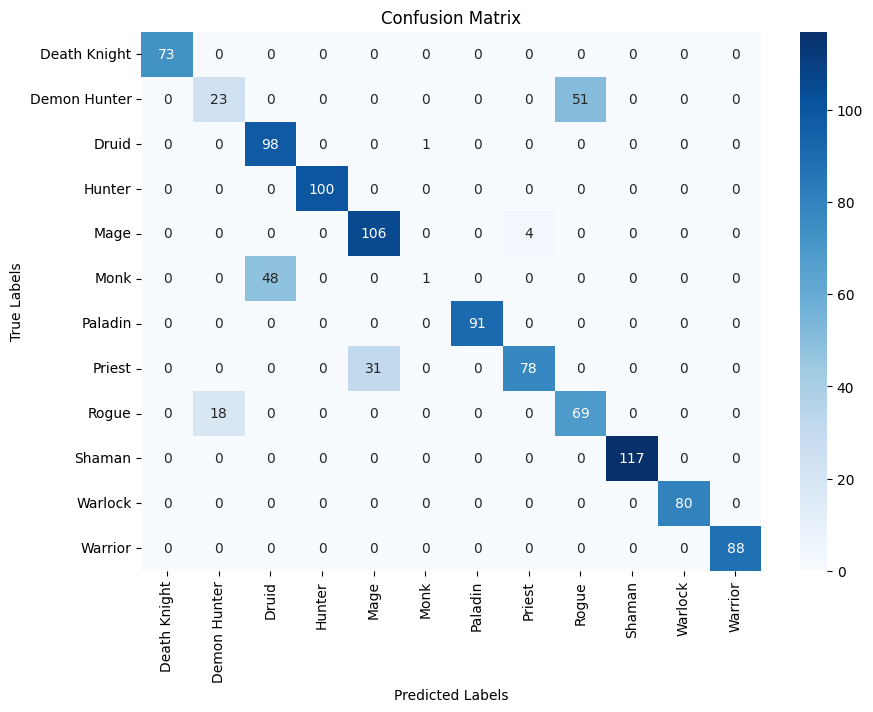

In [45]:
conf_matrix = confusion_matrix(y_test_labels, y_pred_test_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('images/class_cm_nw.png')
plt.show()

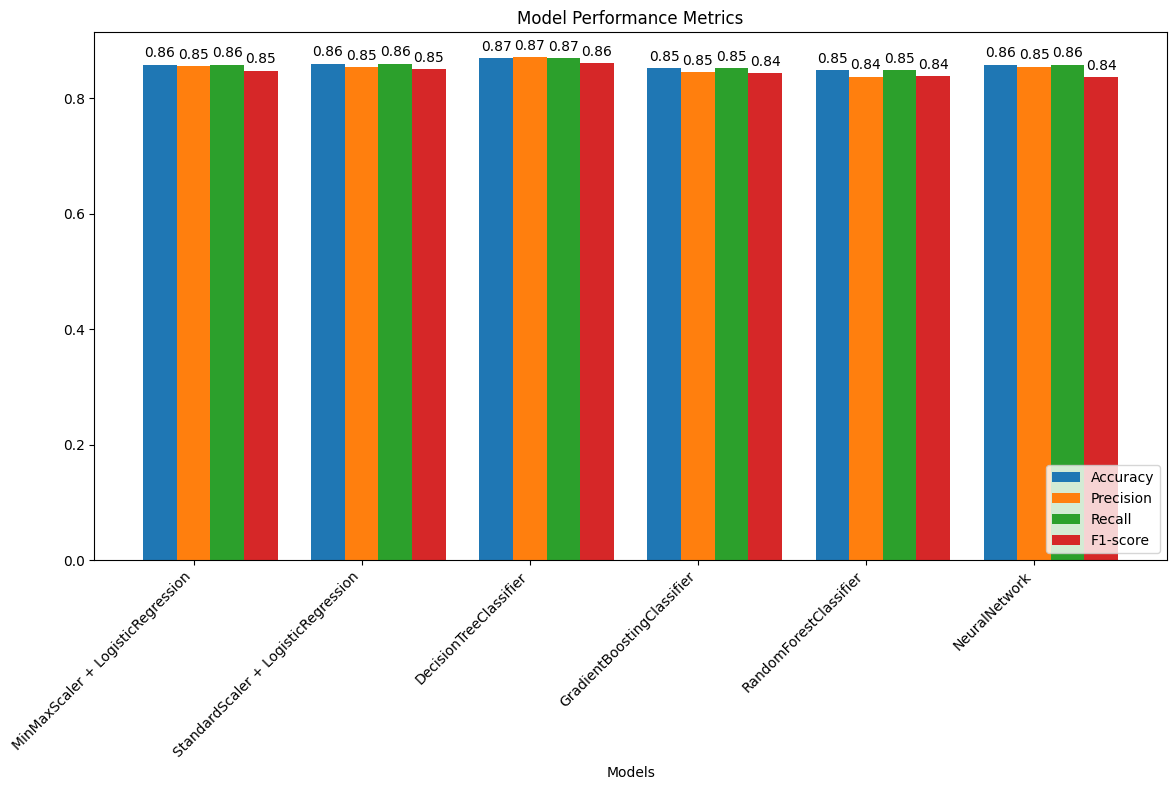

In [46]:
models = {
    "MinMaxScaler + LogisticRegression": {
        "best_params": random_search_minmax.best_params_,
        "accuracy": accuracy_minmax,
        "classification_report": classification_report(y_test_labels_minmax, y_pred_test_labels_minmax, output_dict=True, zero_division=0)
    },
    "StandardScaler + LogisticRegression": {
        "best_params": random_search_standard.best_params_,
        "accuracy": accuracy_standard,
        "classification_report": classification_report(y_test_labels_standard, y_pred_test_labels_standard, output_dict=True, zero_division=0)
    },
    "DecisionTreeClassifier": {
        "best_params": random_search_dt.best_params_,
        "accuracy": accuracy_dt,
        "classification_report": classification_report(y_test_labels_dt, y_pred_test_labels_dt, output_dict=True, zero_division=0)
    },
    "GradientBoostingClassifier": {
        "best_params": random_search_gb.best_params_,
        "accuracy": accuracy_gb,
        "classification_report": classification_report(y_test_labels_gb, y_pred_test_labels_gb, output_dict=True, zero_division=0)
    },
    "RandomForestClassifier": {
        "best_params": random_search_rf.best_params_,
        "accuracy": accuracy_rf,
        "classification_report": classification_report(y_test_labels_rf, y_pred_test_labels_rf, output_dict=True, zero_division=0)
    },
    "NeuralNetwork": {
        "best_params": best_hps.values,
        "accuracy": accuracy,
        "classification_report": classification_report(y_test_labels, y_pred_test_labels, output_dict=True, zero_division=0)
    }
}

model_names = list(models.keys())
accuracies = [models[model]["accuracy"] for model in model_names]
precision_scores = [models[model]["classification_report"]["weighted avg"]["precision"] for model in model_names]
recall_scores = [models[model]["classification_report"]["weighted avg"]["recall"] for model in model_names]
f1_scores = [models[model]["classification_report"]["weighted avg"]["f1-score"] for model in model_names]

x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x, precision_scores, width, label='Precision')
rects3 = ax.bar(x + width, recall_scores, width, label='Recall')
rects4 = ax.bar(x + 2*width, f1_scores, width, label='F1-score')

ax.set_xlabel('Models')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.legend(loc='lower right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.savefig('images/class_summary.png')

plt.show()